# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [159]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

## Load Stations

In [183]:
# Load Unique Stations
station_list = pd.read_csv('data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = 'data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*KAN*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

df = df.reset_index(drop=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

## Time Series Decomposition

In [184]:
# https://datastud.dev/posts/python-seasonality-how-to

In [185]:
# This bit to decompose for each station
for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    

In [188]:
ts = pd.DataFrame() 

for i in df["stid"].unique().tolist():
    
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = df_station['residual'].rolling(window=14).mean()
    df_station['seasonal_residual'] = df_station['residual_smoothed'].fillna(0) + df_station['seasonal']
    
    df_station['stid'] = i # Add a column for the current station
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [190]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [191]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [149]:
df["stid"].unique().tolist()

['KAN_B', 'KAN_U', 'KAN_L', 'KAN_M']

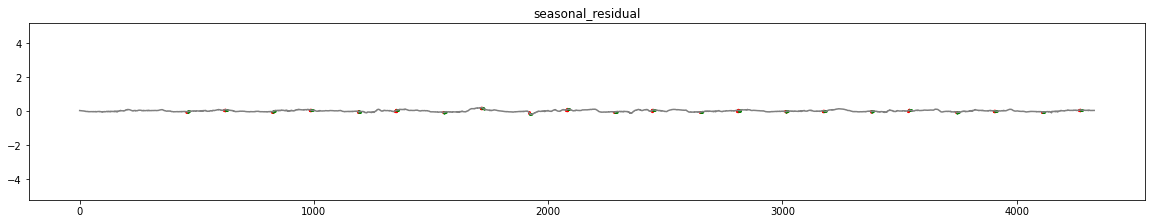

In [201]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
    pre_max_indices = df[df['Periods'] == 'pre_max'].index
    plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    post_max_indices = df[df['Periods'] == 'post_max'].index
    plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    pre_min_indices = df[df['Periods'] == 'pre_min'].index
    plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    post_min_indices = df[df['Periods'] == 'post_min'].index
    plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual, c = "grey")

plt_seasonal_residual(df,"KAN_B")


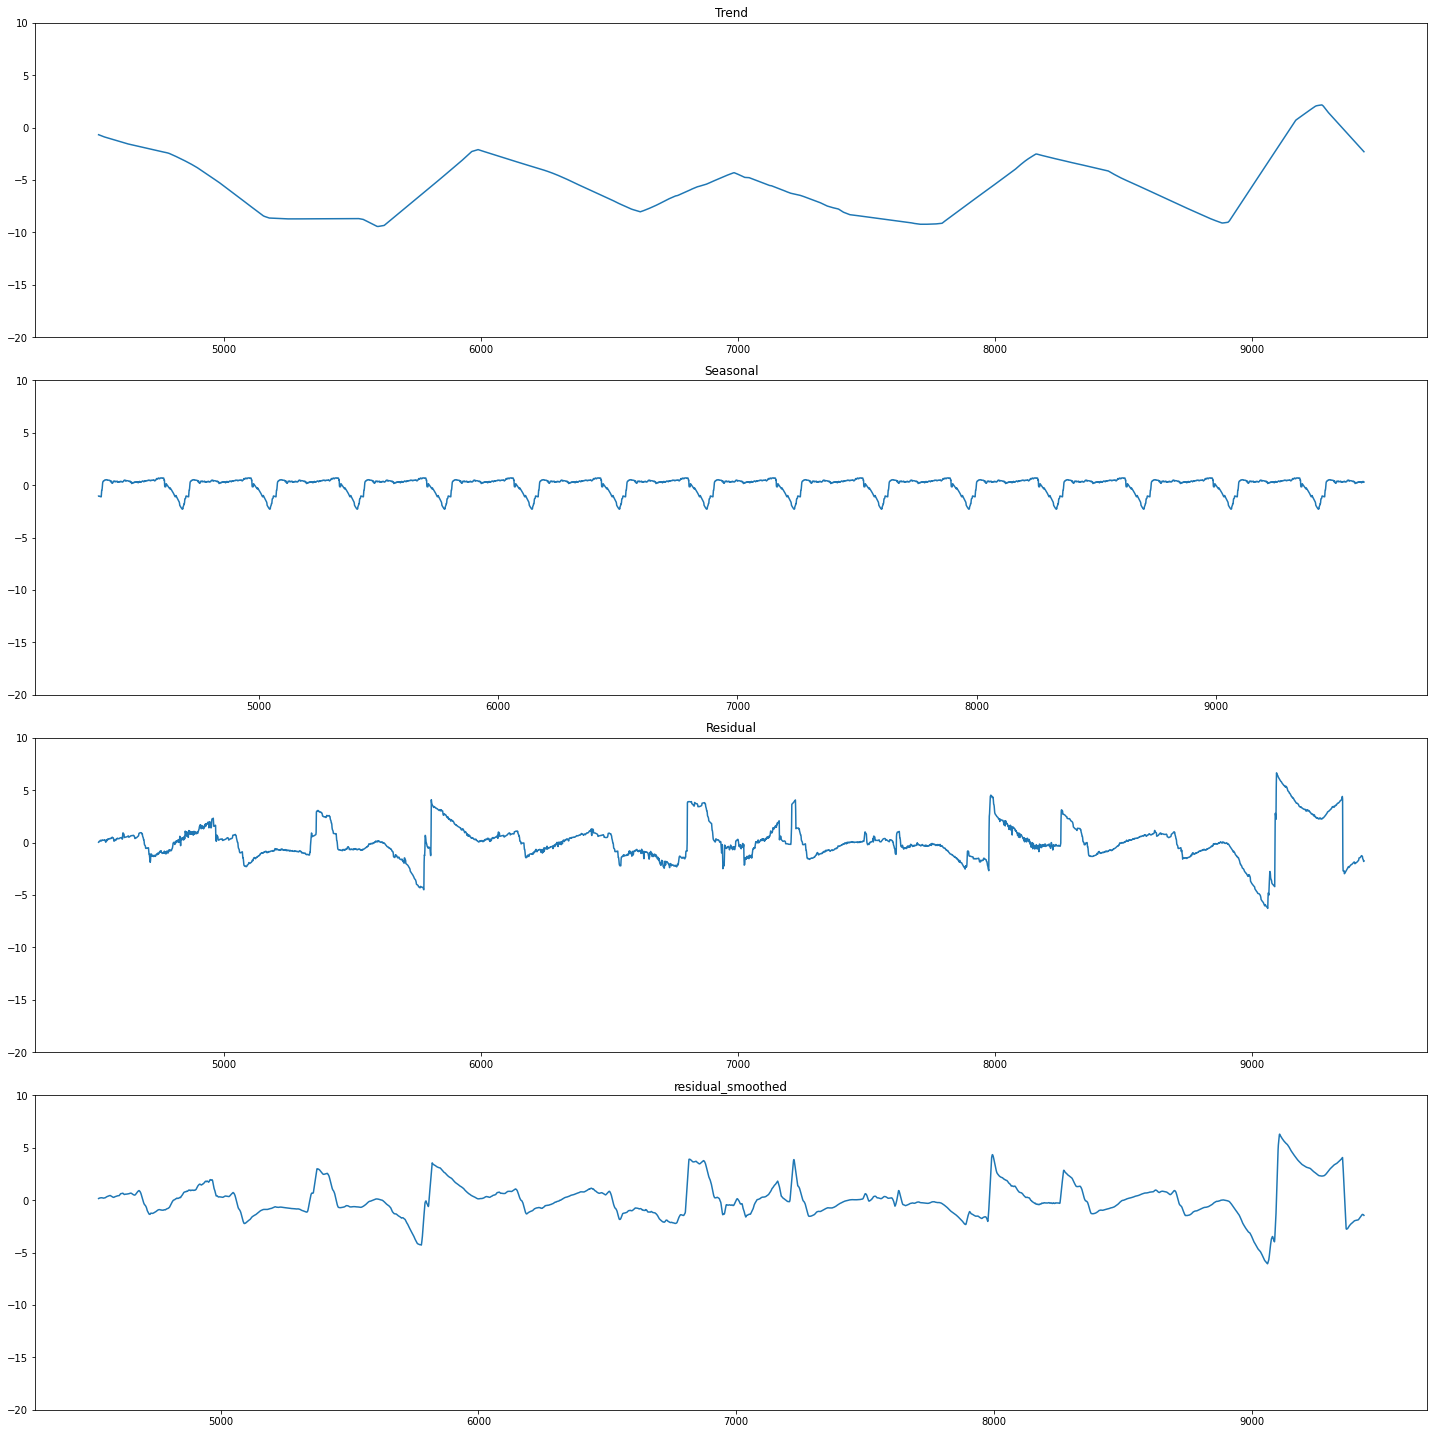

In [204]:
plot_components(df, 'KAN_U')

## Regression Analysis

##### Set target variable

In [205]:
y = 'seasonal_residual'

##### Pre-processing (0.1: Change months to cycle)

In [206]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

To do: Transform the Wind direction into cyclical where it is non NAN so that we do not need to remove all NAN from df

In [207]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
#df = df[df['Wind from direction (upper boom)'].notna()] 

# Exclude not needed columns in exclude list
#cyclical = cyclical.fit_transform(df[['month',  'day','Wind from direction (upper boom)']]) 

# Exclude not needed columns in exclude list
cyclical = cyclical.fit_transform(df[['month',  'day']]) 

df = pd.merge(df, cyclical, left_index=True, right_index=True)

#df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

##### Pre-processing (1.0: Filter relevant periods)

In [208]:
df = df[df[y].notna()] 

In [210]:
df = df.reset_index(drop=True)

In [211]:
# This bit retrieve the indexes for all melting season categories and remove column from df
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

for category in ['pre_max', 'post_max', 'pre_min', 'post_min']:
    exec(f"indices_{category} = df[df['Periods'] == '{category}'].index")

##### Pre-processing (2.0: Formatting and transformation)

In [212]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

{'KAN_B': 0, 'KAN_L': 1, 'KAN_M': 2, 'KAN_U': 3}

In [213]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
               # 'day_sin',
               # 'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods'
                #'seasonal_residual'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [214]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual'
              'residual_smoothed'
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [227]:
from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=2023, shuffle=False)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

## Regression Modelling

In [248]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np

# Create regression models
models = [
    #("Linear Regression", LinearRegression()),
    #("Decision Tree", DecisionTreeRegressor()),
    #("Random Forest", RandomForestRegressor()),
    ("HistGradient Boosting", HistGradientBoostingRegressor()),
    ("XGBoost", XGBRegressor(objective="reg:squarederror", missing=np.nan, verbosity=0)),
    ("Neural Network", Sequential([
            Dense(32, activation="relu", input_dim=X_train.shape[1]),
            Dense(16, activation="relu"),
            Dense(1)
        ])),
    ("LSTM", Sequential([
            LSTM(32, activation="relu", input_shape=(X_train.shape[1],1)),
            Dense(16, activation="relu"),
            Dense(1)
        ])),
    ("CNN", Sequential([
            Conv1D(32, 3, activation="relu", input_shape=(X_train.shape[1],1)),
            MaxPooling1D(),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(1)
        ]))
]

# Train and evaluate models
for name, model in models:
    print("Training", name)
    if name == "Neural Network":
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test)
        model.compile(loss="mean_squared_error", optimizer="adam")
        model.fit(X_train_imp, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = model.predict(X_test_imp)

    elif name == "LSTM":
        model.compile(loss="mean_squared_error", optimizer="adam")
        #model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=0)
        model.fit(X_train_imp, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = model.predict(X_test_imp)
        
    elif name == "CNN":
        model.compile(loss="mean_squared_error", optimizer="adam")
        #model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=0)
        model.fit(X_train_imp, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = model.predict(X_test_imp)
        
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(name, "MSE:", mse)
    print(name, "R^2:", r2)
    

Training HistGradient Boosting
HistGradient Boosting MSE: 0.015618197482211904
HistGradient Boosting R^2: 0.06470435917047901
Training XGBoost
XGBoost MSE: 0.015954254052537416
XGBoost R^2: 0.04457961393943999
Training Neural Network
Neural Network MSE: 0.017889022379360974
Neural Network R^2: -0.07128397301763978
Training LSTM
LSTM MSE: 0.01622729311861903
LSTM R^2: 0.028228671484451184
Training CNN
CNN MSE: 0.016655663513382848
CNN R^2: 0.0025757135589711266


In [ ]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|█████████▍                                  | 9/42 [00:16<01:16,  2.31s/it]

-------

## Selected Models

In [116]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [238]:
station_names = dict(zip(le.classes_, le.transform(le.classes_)))
for station_name, value in enumerate(station_names):
    print(station_name, value)

0 KAN_B
1 KAN_L
2 KAN_M
3 KAN_U


Best hyperparameters_seasonal_residual:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (seasonal_residual):  0.062343408371125286
MSE on test set (seasonal_residual):  0.015657622231158012
KAN_B 0


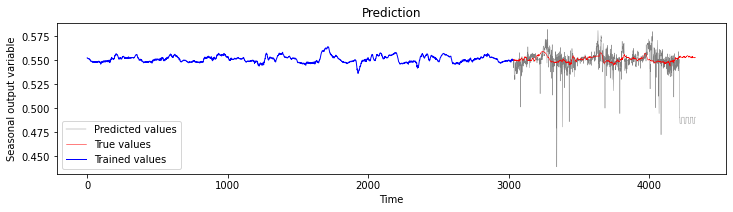

KAN_L 1


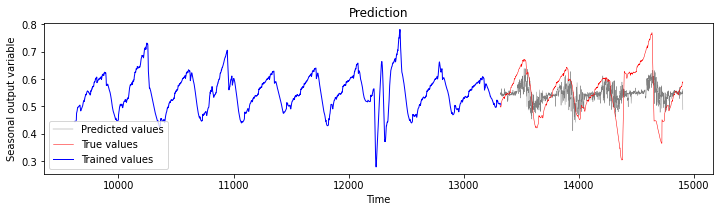

KAN_M 2


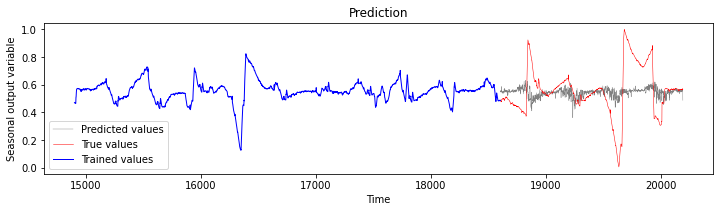

KAN_U 3


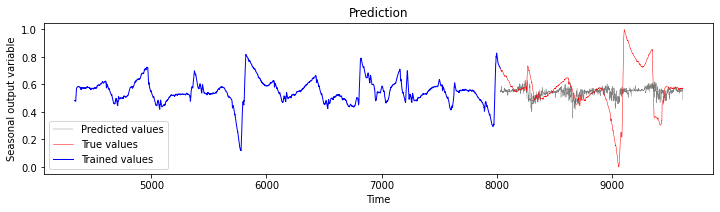

/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-pa

In [247]:
# Light GBM

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_child_weight': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'n_estimators': [100],#[100, 500, 1000],
    'subsample': [0.5],#[0.5, 0.7, 1.0],
    'colsample_bytree': [0.5],#[0.5, 0.7, 1.0],
    'reg_alpha': [0],#[0, 0.1, 0.5],
    'reg_lambda': [0.1],#[0, 0.1, 0.5]
}

# Define the LightGBM regressor model
model = lgb.LGBMRegressor()

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)

# Save the best model parameters as 'model' variable
exec(f"gbm_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"gbm_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"gbm_model_{y}").predict(X_test_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


Best hyperparameters_seasonal_residual:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (seasonal_residual):  0.26341683079893585
MSE on test set (seasonal_residual):  0.02596921000870881


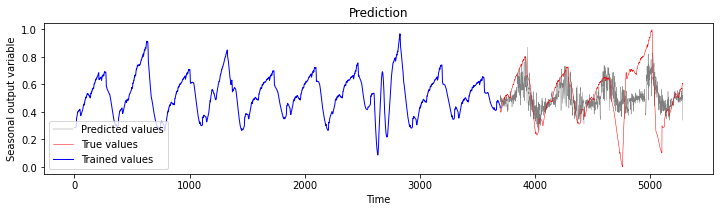

In [118]:
# XGB Regressor
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_child_weight': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'n_estimators': [100],#[100, 500, 1000],
    'subsample': [0.5],#[0.5, 0.7, 1.0],
    'colsample_bytree': [0.5],#[0.5, 0.7, 1.0],
    'reg_alpha': [0],#[0, 0.1, 0.5],
    'reg_lambda': [0.1],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)

# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"gbm_model_{y}").predict(X_test_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


R^2 score on test set (seasonal_residual):  0.27252338814476207
MSE on test set (seasonal_residual):  0.025648146332455365


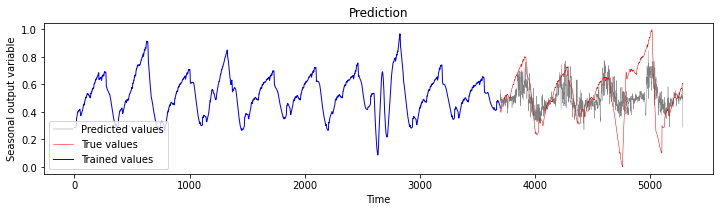

In [119]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_samples_leaf': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'max_iter': [100],#[100, 500, 1000],
    'l2_regularization': [0.5],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set

# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"gbm_model_{y}").predict(X_test_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


## Filter by Melting Season and get feature importances 

In [120]:
import shap
explainer = eval(f"shap.Explainer(hist_model_{y})")

Summary for pre_max


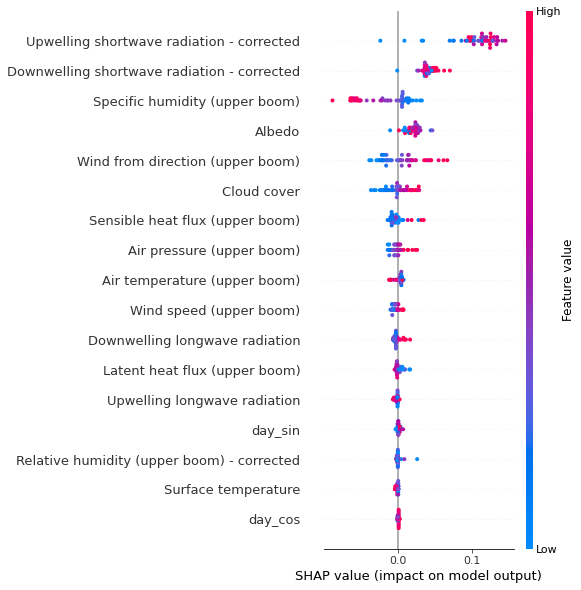

Summary for post_max


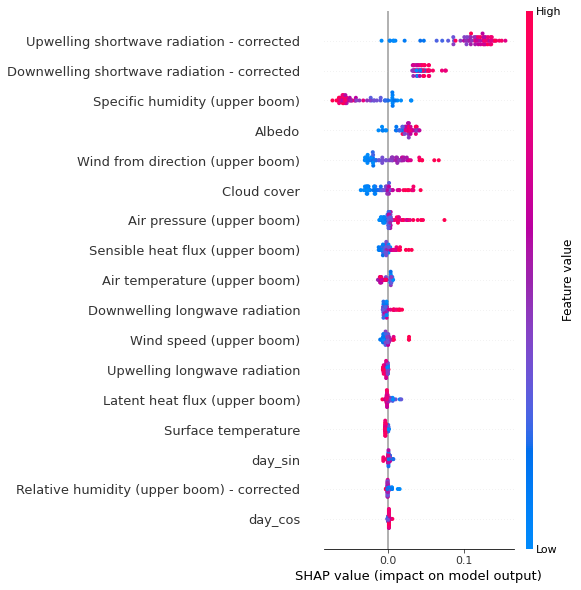

Summary for pre_min


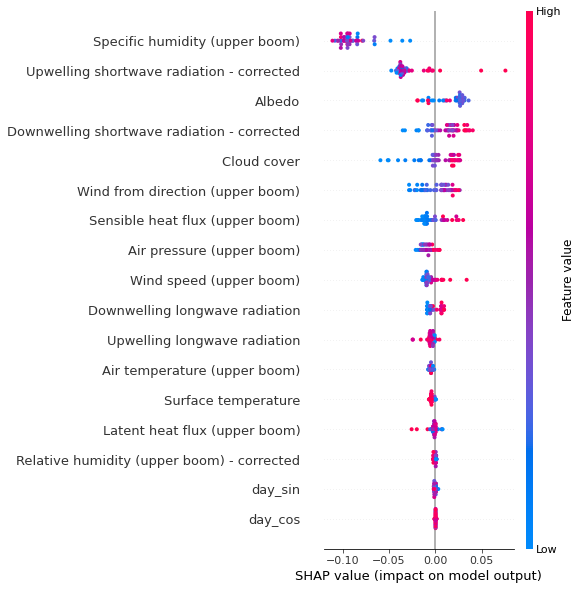

Summary for post_min


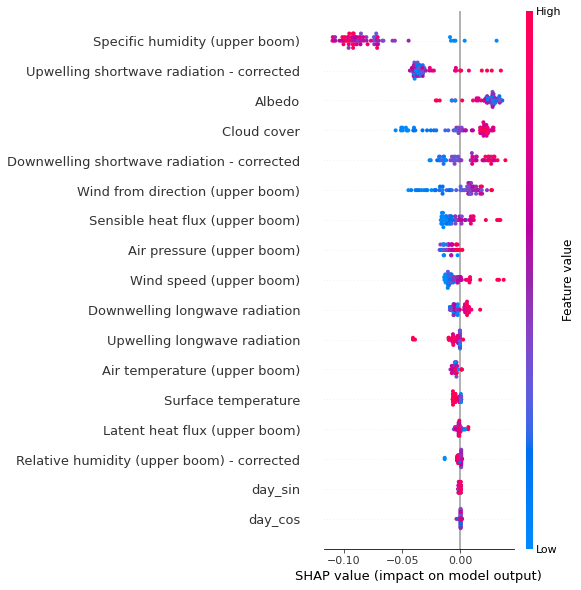

In [121]:
for category in ['pre_max', 'post_max', 'pre_min', 'post_min']:
    # Get the indices for the current category
    indices = eval(f"indices_{category}")
    
    # Filter X_train and shap_values based on the selected indices
    X_Train_valid_indices = indices.intersection(X_train.index).to_list()
    X_train_filtered = X_train.iloc[X_Train_valid_indices]
    shap_values_filtered = explainer(X_train_filtered)

    # Plot the force plot for the selected indices
    #shap.force_plot(explainer.expected_value, shap_values_filtered, X_train_filtered)
    print("Summary for",category)
    shap.summary_plot(shap_values_filtered, X_train_filtered)

-------

In [1398]:
shap_values = explainer(df)

clustering = shap.utils.hclust(X_train, y_train)

shap.plots.bar(shap_values, clustering=clustering)

IndexError: index 17 is out of bounds for axis 1 with size 17

In [1399]:
pd.DataFrame(shap_values.data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.64,0.46,0.40,0.09,0.47,124.33,0.47,0.39,0.21,0.47,0.57,0.41,0.28,0.32,0.09,0.64,0.20,0.98
1,0.59,0.62,0.33,0.17,0.32,129.07,0.42,0.35,0.36,0.61,0.71,0.41,0.32,0.33,0.15,0.64,0.39,0.92
2,0.55,0.68,0.35,0.22,0.26,134.93,0.39,0.32,0.42,0.68,0.78,0.42,0.28,0.32,0.19,0.64,0.57,0.82
3,0.59,0.58,0.54,0.17,0.18,110.85,0.47,0.37,0.36,0.63,0.74,0.45,0.18,0.28,0.22,0.64,0.72,0.69
4,0.61,0.50,0.84,0.15,0.06,113.48,0.42,0.43,0.45,0.56,0.66,0.47,0.13,0.55,0.58,0.64,0.85,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887,0.71,0.83,0.95,0.60,0.07,101.66,0.39,0.31,0.83,0.94,0.99,0.49,0.15,0.28,0.84,0.11,-0.49,-0.87
4888,0.68,0.82,0.62,0.46,0.18,104.03,0.58,0.47,0.58,0.91,0.98,0.42,0.19,0.29,0.26,0.10,-0.65,-0.76
4889,0.60,0.81,0.87,0.55,0.09,154.66,0.25,0.21,0.81,0.93,0.99,0.48,0.15,0.38,0.83,0.10,-0.79,-0.61
4890,0.67,0.82,0.88,0.56,0.09,140.78,0.48,0.42,0.76,0.93,1.00,0.47,0.16,0.39,0.68,0.10,-0.90,-0.44


In [1403]:
shap.force_plot(explainer.expected_value[indices_pre_max.to_list()], shap_values[indices_pre_max.to_list()])

IndexError: index 55 is out of bounds for axis 0 with size 1

In [1408]:
shap.initjs()
shap.force_plot(shap_values[55])

In [1401]:
indices_pre_max.to_list()

[55,
 56,
 57,
 58,
 59,
 420,
 421,
 422,
 423,
 424,
 785,
 786,
 787,
 788,
 789,
 1150,
 1151,
 1152,
 1153,
 1154,
 1515,
 1516,
 1517,
 1518,
 1519,
 1880,
 1881,
 1882,
 1883,
 1884,
 2245,
 2246,
 2247,
 2248,
 2249,
 2610,
 2611,
 2612,
 2613,
 2614,
 2975,
 2976,
 2977,
 2978,
 2979,
 3340,
 3341,
 3342,
 3343,
 3344,
 3705,
 3706,
 3707,
 3708,
 3709,
 4070,
 4071,
 4072,
 4073,
 4074,
 4435,
 4436,
 4437,
 4438,
 4439,
 4800,
 4801,
 4802,
 4803,
 4804]

In [1397]:
X_test

,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,Surface temperature,Latent heat flux (upper boom),Sensible heat flux (upper boom),Albedo,Cloud cover,day_sin,day_cos
3424,0.53,0.85,0.94,0.65,0.11,58.96,0.25,0.18,0.87,0.93,1.00,0.51,0.18,0.20,0.89,-0.10,-0.99
3425,0.57,0.87,0.79,0.62,0.15,95.27,0.33,0.23,0.83,0.93,1.00,0.50,0.22,0.18,0.75,-0.30,-0.95
3426,0.56,0.88,0.52,0.53,0.20,82.30,0.64,0.45,0.60,0.92,1.00,0.45,0.27,0.18,0.15,-0.49,-0.87
3427,0.58,0.85,0.60,0.51,0.14,69.77,0.46,0.34,0.66,0.91,0.99,0.46,0.20,0.23,0.39,-0.65,-0.76
3428,0.59,0.88,0.55,0.54,0.22,93.83,0.58,0.40,0.72,0.93,1.00,0.45,0.28,0.17,0.47,-0.79,-0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887,0.71,0.83,0.95,0.60,0.07,101.66,0.39,0.31,0.83,0.94,0.99,0.49,0.15,0.28,0.84,-0.49,-0.87
4888,0.68,0.82,0.62,0.46,0.18,104.03,0.58,0.47,0.58,0.91,0.98,0.42,0.19,0.29,0.26,-0.65,-0.76
4889,0.60,0.81,0.87,0.55,0.09,154.66,0.25,0.21,0.81,0.93,0.99,0.48,0.15,0.38,0.83,-0.79,-0.61
4890,0.67,0.82,0.88,0.56,0.09,140.78,0.48,0.42,0.76,0.93,1.00,0.47,0.16,0.39,0.68,-0.90,-0.44


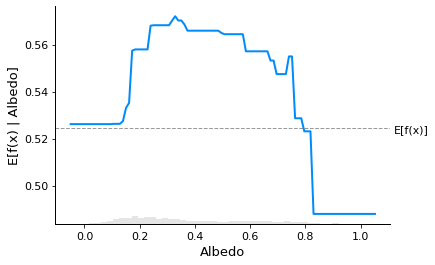

/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-pa

In [1388]:
shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X_train, ice=False, model_expected_value=True, feature_expected_value=True)
#eval(f"model_{y}")


--------